# Summary

This notebook will walk through two different access and transformation options available in the Earthdata Cloud: 
1. Direct s3 access using the [earthaccess](https://github.com/nsidc/earthaccess) python library
2. Data subsetting using the [Harmony-py](https://github.com/nasa/harmony-py) python library 

These steps are based off of several notebook tutorials presented during the [2021 Earthdata Cloud Hackathon](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/) and [2021 AGU Workshop](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/), as well as NSIDC DAAC's [Accessing and working with ICESat-2 data in the cloud](https://github.com/nsidc/NSIDC-Data-Tutorials/tree/main/notebooks/ICESat-2_Cloud_Access) tutorial.

TODO: Update description of data:

Science use cases: 
* Direct access IS2 sea ice height; Multifile time series
* Then, subset L2 SST:
    * GHRSST Level 2P Global Sea Surface Skin Temperature from the Moderate Resolution Imaging Spectroradiometer (MODIS) on the NASA Aqua satellite (GDS2) (C1940473819-POCLOUD) (MODIS_A-JPL-L2P-v2019.0)


We will access a single NetCDF file from the GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis (v4.1) dataset (MUR-JPL-L4-GLOB-v4.1) inside the AWS cloud (us-west-2 region, specifically) and load it into Python as an `xarray` `dataset` using the `earthaccess` python library.  

After inspecting the data, we will then access the same file, but in this case we will also subset the data to our area of interest using Harmony. 

## Learning Objectives (TODO: Need to update)

- how to retrieve temporary S3 credentials for in-region direct S3 bucket access
- how to define a dataset of interest and find netCDF files in S3 bucket
- how to perform in-region direct access of MODIS_T-JPL-L2P-v2019.0 data in S3
- how to plot the data


1. Conceptualize the data transformation service types and offerings provided by NASA Earthdata, including Harmony.
2. Practice skills learned from the introductory CMR tutorial to discover what access and service options exist for a given data set, as well as variable metadata.
3. Utilize the Harmony-py library to request subsetted MODIS L2 Sea Surface Temperature data over the Gulf of Mexico. 
4. Read Harmony subsetted outputs directly into xarray. 

---

# 1. Prerequisites

## AWS instance running in us-west-2

NASA Earthdata Cloud data in S3 can be directly accessed via temporary credentials; this access is limited to requests made within the US West (Oregon) (code: us-west-2) AWS region.

TODO: Back up and walk through what S3 is and the fact that the Hub is running in us-west-2

## Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit <https://urs.earthdata.nasa.gov> to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.


---

## Import Required Packages

In [1]:
# earthaccess
import earthaccess 

# Direct access

#import requests
import s3fs
from pprint import pprint
import xarray as xr

# Harmony

from harmony import BBox, Client, Collection, Request, LinkType
import datetime as dt

## 1. Authentication for NASA Earthdata 

The first step is to get the correct authentication that will allow us to get cloud-hosted data from NASA. This is all done through Earthdata Login. The `login` method also gets the correct AWS credentials.

In [2]:
auth = earthaccess.login(strategy="interactive", persist=True)

Enter your Earthdata Login username:  amy.steiker
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 06/16/2023
Using user provided credentials for EDL
Persisting credentials to .netrc


___
## 2. Accessing an HDF5 file using S3 Direct Access

### Summary

![](images/earthaccess-intro.png){fig-alt=“Text says earthaccess python library is an open-source library to simplify Earthdata Cloud search and access width=25%}

### Search for data

`earthaccess` leverages the Common Metadata Repository (CMR) API to search for collections and granules. Earthdata Search also uses the CMR API.

We can use the keyword method for collection_query to search for ICESat-2 collections.

TODO: Write Issue in earthaccess to see if we could search on doi using search_data()

TODO: Point to landing page and/or Earthdata Search link to locate short name)

ICESat-2 example: https://search.earthdata.nasa.gov/search?q=ATL07%20V005&ff=Available%20in%20Earthdata%20Cloud  

In [3]:
l4_short_name="MUR-JPL-L4-GLOB-v4.1"
# short_name="ATL07"

results = earthaccess.search_data(
    #doi="10.5067/GHGMR-4FJ04",
    short_name=l4_short_name,
    cloud_hosted=True,
    temporal=("2021-08-01", "2021-8-31"),
    # temporal=("2021-01-01", "2021-01-15"),
    bounding_box=(-125.469,15.820,-99.453,35.859)
    # bounding_box=(-42.60274,-74.02897,-28.63822,-64.97912)
)

Granules found: 31


Discover information about the matching files:

In [4]:
pprint(results[0])

{'meta': {'concept-id': 'G2098044659-POCLOUD',
          'concept-type': 'granule',
          'format': 'application/vnd.nasa.cmr.umm+json',
          'native-id': '20210801090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
          'provider-id': 'POCLOUD',
          'revision-date': '2021-11-14T21:35:22.530Z',
          'revision-id': 11},
 'size': 0,
 'umm': {'CollectionReference': {'ShortName': 'MUR-JPL-L4-GLOB-v4.1',
                                 'Version': '4.1'},
         'DataGranule': {'ArchiveAndDistributionInformation': [{'Checksum': {'Algorithm': 'MD5',
                                                                             'Value': '899e042667770434a6ae37f40078b5a1'},
                                                                'Name': '20210801090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
                                                                'Size': 713.4013319015503,
                                                                'SizeInBy

### Direct In-region Access

Our code will work the same way if we are running it in the cloud or from our laptop.

Stream data directly to xarray. `earthaccess` requires that we use the `open_mfdataset()` method.

In [5]:
ds = xr.open_mfdataset(earthaccess.open(results))
ds

 Opening 31 granules, approx size: 0.0 GB


SUBMITTING | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/31 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:           (time: 31, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2021-08-01T09:00:00 ... 2021-08-3...
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [6]:
ds_subset = ds['analysed_sst'].sel(lat=slice(15.820, 35.859), lon=slice(-125.469,-99.453))
ds_subset

<xarray.DataArray 'analysed_sst' (time: 31, lat: 2004, lon: 2601)>
dask.array<getitem, shape=(31, 2004, 2601), dtype=float32, chunksize=(1, 2004, 2601), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-08-01T09:00:00 ... 2021-08-31T09:00:00
  * lat      (lat) float32 15.82 15.83 15.84 15.85 ... 35.82 35.83 35.84 35.85
  * lon      (lon) float32 -125.5 -125.4 -125.4 -125.4 ... -99.48 -99.47 -99.46
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, A...

From https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/09_Zarr_Access.html: 

In [7]:
ds_subset.load();

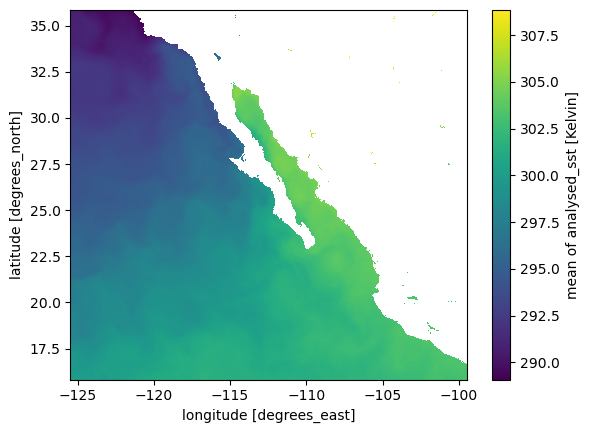

In [10]:
mean_sst = ds_subset.mean('time')
mean_sst.name = 'mean of analysed_sst [Kelvin]'
mean_sst.plot();

---

## 3. Accessing Multiple NetCDF4 Files - Data Subsetting and Transformation Services in the Cloud

### Using the Harmony-Py library to access customized data from NASA Earthdata 

### Summary

In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection, and other transformations. 

![](images/subsetting_diagram.png){fig-alt="" width=25%}

We will now find, request, and use customized data from using [Harmony](https://harmony.earthdata.nasa.gov/).


## Using Harmony-Py to subset data

Harmony-Py provides a pip installable Python alternative to directly using Harmony's RESTful API to make it easier to request data and service options, especially when interacting within a Python Jupyter Notebook environment.

The next steps are adopted from the [introduction tutorial](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) notebook provided in the Harmony-Py library:

### Create Harmony Client object
First, we need to create a Harmony Client, which is what we will interact with to submit and inspect a data request to Harmony, as well as to retrieve results.

When creating the Client, we need to provide Earthdata Login credentials, which are required to access data from NASA EOSDIS. This basic line below assumes that we have a `.netrc` available. 

In [74]:
harmony_client = Client()

### Create Harmony Request

The following are common request parameters:

- `collection`: Required parameter. This is the NASA EOSDIS collection, or data product. There are two options for inputting a collection of interest:
    - Provide a concept ID (e.g. C1940473819-POCLOUD)
    - Data product short name (e.g. MODIS_A-JPL-L2P-v2019.0).
- `spatial`: Bounding box spatial constraints on the data. The Harmony Bbox class accepts spatial coordinates as decimal degrees in w, s, e, n order, where longitude = -180, 180 and latitude = -90, 90.
- `temporal`: Date/time constraints on the data. The example below demonstrates temporal start and end ranges using the python datetime library.

As we identified above, only subsetting options are available for this dataset. If other service options such as reformatting are available for a given dataset, these can also be specified using Harmony-py: See the [documentation](https://harmony-py.readthedocs.io/en/latest/) for details on how to construct these parameters.


In [55]:
l2_short_name = "MODIS_A-JPL-L2P-v2019.0"

request = Request(
    collection=Collection(id=GPM_short_name),
    spatial=BBox(-125.469,15.820,-99.453,35.859),
    temporal={
    'start': dt.datetime(2021, 8, 1),
    'stop': dt.datetime(2021, 8, 2)
    },
    # format='application/x-zarr',
    # concatenate=True,
    # max_results=10,
)

In [78]:
## testing giovanni

GPM_short_name = "GPM_3IMERGHH"

request = Request(
    collection=Collection(id=GPM_short_name),
    variables=['Grid/IRprecipitation'],
    spatial=BBox(91.4,25.3,91.6,25.3),
    temporal={
    'start': dt.datetime(2001, 1, 1),
    'stop': dt.datetime(2014, 12, 31)
    },
    format='text/csv',
    # concatenate=True,
    # max_results=10,
)

In [ ]:
# next will be to test HOSS / Shapefile


### Submit request

Now that the request is created, we can now submit it to Harmony using the Harmony Client object. A job id is returned, which is a unique identifier that represents the submitted request.

In [79]:
job_id = harmony_client.submit(request)
job_id

KeyError: 'jobID'

### Check request status

Depending on the size of the request, it may be helpful to wait until the request has completed processing before the remainder of the code is executed. The wait_for_processing() method will block subsequent lines of code while optionally showing a progress bar.

In [57]:
harmony_client.wait_for_processing(job_id, show_progress=True)
#harmony_client.resume(job_id)

 [ Processing: 100% ] |###################################################| [|]


### View Harmony job response and output URLs
Once the data request has finished processing, we can view details on the job that was submitted to Harmony, including the API call to Harmony, and informational messages on the request if available.

result_json() calls wait_for_processing() and returns the complete job in JSON format once processing is complete. 

In [58]:
data = harmony_client.result_json(job_id)
pprint(data)

{'createdAt': '2023-05-25T21:51:52.912Z',
 'dataExpiration': '2023-06-24T21:51:52.912Z',
 'jobID': 'd4f46094-5531-47c0-82c2-902c44f5c46e',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/stac/d4f46094-5531-47c0-82c2-902c44f5c46e/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'href': 'https://harmony.earthdata.nasa.gov/cloud-access.sh',
            'rel': 'cloud-access-sh',
            'title': 'Access keys for s3:// URLs, usable from AWS us-west-2 '
                     '(Shell format)',
            'type': 'application/x-sh'},
           {'href': 'https://harmony.earthdata.nasa.gov/cloud-access',
            'rel': 'cloud-access-json',
            'title': 'Access keys for s3:// URLs, usable from AWS us-west-2 '
                     '(JSON format)',
            'type': 'application/json'},
           {'href': 's3://harmony-prod-staging/public/d4f46094-5531-47c0-82c2-902c44f5c46e/',
          

### Direct cloud access

Note that the remainder of this tutorial will only succeed when running this notebook within the AWS us-west-2 region.

Harmony data outputs can be accessed within the cloud using the s3 URLs and AWS credentials provided in the Harmony job response.

#### Retrieve list of output URLs.

The result_urls() method calls wait_for_processing() and returns a list of the processed data URLs once processing is complete. You may optionally show the progress bar as shown below.

In [59]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)
url = urls[0]
print(url)

s3://harmony-prod-staging/public/d4f46094-5531-47c0-82c2-902c44f5c46e/14461204/20210801090501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.zarr


Using `aws_credentials` you can retrieve the credentials needed to access the Harmony s3 staging bucket and its contents.

In [60]:
creds = harmony_client.aws_credentials()

### Open staged files with *s3fs* and *xarray*

We use the AWS `s3fs` package to create a file system that can then be read by xarray:

In [61]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

Now that we have our s3 file system set, including our declared credentials, we'll use that to open the url, and read in the file through xarray. This extra step is needed because xarray cannot open the S3 location directly. Instead, the S3 file object is passed to xarray, in order to then open the dataset. 

In [68]:
f = s3_fs.open(url, mode='rb')
# ds = xr.open_dataset(f, drop_variables=['time'])
ds = xr.open_dataset(f, engine='zarr')
ds

ValueError: Starting with Zarr 2.11.0, stores must be subclasses of BaseStore, if your store exposes the MutableMapping interface wrap it in Zarr.storage.KVStore. Got <File-like object S3FileSystem, harmony-prod-staging/public/d4f46094-5531-47c0-82c2-902c44f5c46e/14461204/20210801090501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.zarr>

### Plot the data

Use the xarray built in plotting function to create a simple plot along the x and y dimensions of the dataset:

In [23]:
ds.load();

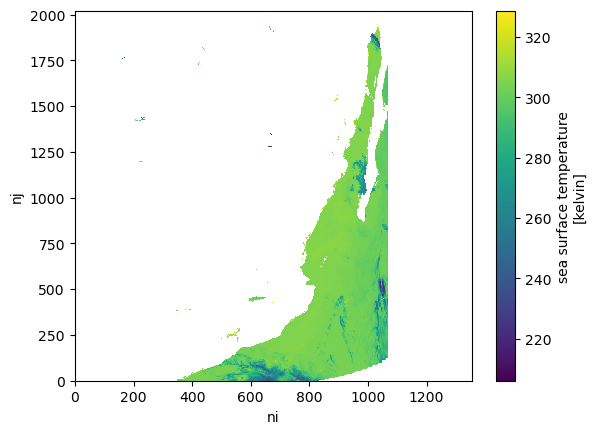

In [50]:
#ds.sea_surface_temperature.plot() ;
sst = ds.sea_surface_temperature.isel(subset_index=6)
sst.plot() ;

In [26]:
# import hvplot.xarray
# ds['sea_surface_temperature'].hvplot(kind='scatter', s=2)

# Create time series

### Conclusion

How do I end my session?
(Also see [How do I end my Openscapes session? Will I lose all of my work?](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/clinic/jupyterhub.html#how-do-i-end-my-openscapes-session))

When you are finished working for the day it is important to explicitly log out of your Openscapes session. The reason for this is it will save us a bit of money! When you keep a session active it uses up AWS resources and keeps a series of virtual machines deployed.

Stopping the server happens automatically when you log out, so navigate to “File -> Log Out” and just click “Log Out”!

::: callout-important
Logging out will NOT cause any of your work to be lost or deleted. It simply shuts down some resources. It would be equivalent to turning off your desktop computer at the end of the day.
:::


This notebook demonstrated an abbreviated and simplified workflow to explore access and subsetting options available through the Earthdata Cloud. There are several other options that can be used to work "in place" in the Earthdata Cloud, from data discovery to analysis-ready data, including: 

* [Zarr-EOSDIS-Store](https://github.com/nasa/zarr-eosdis-store)
    * The zarr-eosdis-store library allows NASA EOSDIS Collections to be accessed efficiently by the Zarr Python library, provided they have a sidecar DMR++ metadata file generated. 
    * Tutorial highlighting this library's usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/09_Zarr_Access.html 
* [OPeNDAP](https://opendap.earthdata.nasa.gov/) 
    * Hyrax provides direct access to subsetting of NASA data using Python or your favorite analysis tool
    * Tutorial highlighting OPeNDAP usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/06_S6_OPeNDAP_Access_Gridding.html
* [Earthaccess Library](https://github.com/nsidc/earthdaccess)
    * A Python library to search and access NASA Earthdata datasets, aiming to provide a simple way to access or download data without having to worry if a given dataset is on-prem or in the cloud.
    
TODO Cleanup: See the [appendix]("https://nasa-openscapes.github.io/earthdata-cloud-cookbook/appendix/authentication.html") for more information on [Earthdata Login]("https://urs.earthdata.nasa.gov/") and netrc setup. This basic line below to create an earthaccess Client assumes that we have a .netrc available.    